In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## import library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, VGG19, InceptionV3, InceptionResNetV2, VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!nvidia-smi

2024-05-31 16:15:00.345585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:15:00.345708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:15:00.508606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Fri May 31 16:15:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load Dataset

In [3]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [4]:
# bagi data train dan test
# direktory
train_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test' 

weight, height = 32, 32
batch_size = 32

# normalize pixel data
train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_data_gen.flow_from_directory(
    train_path,
    target_size = (weight, height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)
test_dataset = test_data_gen.flow_from_directory(
    test_path,
    target_size = (weight, height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
# check kelas
train_dataset.class_indices

{'FAKE': 0, 'REAL': 1}

## Skenario 1

In [6]:
# mendefinisikan model
model1 = models.Sequential()

# convolutional layers
model1.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(weight, height, 3) ))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model1.add(layers.Flatten())

# dense layers
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# optimizer adam dan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model1.compile(optimizer= optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [8]:
# summary model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model1.fit(train_dataset,
                    epochs = 100,
                    validation_data = test_dataset,callbacks=[callback])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   3/3125 ━━━━━━━━━━━━━━━━━━━━ 4:02 78ms/step - accuracy: 0.4601 - loss: 0.7091 - precision: 0.4520 - recall: 0.6244  

I0000 00:00:1717172150.973568      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717172150.992867      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3118/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.8008 - loss: 0.4182 - precision: 0.7946 - recall: 0.8133

W0000 00:00:1717172813.506936      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 788s 249ms/step - accuracy: 0.8009 - loss: 0.4180 - precision: 0.7947 - recall: 0.8134 - val_accuracy: 0.8892 - val_loss: 0.2688 - val_precision: 0.8522 - val_recall: 0.9419
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 196s 63ms/step - accuracy: 0.8972 - loss: 0.2509 - precision: 0.8988 - recall: 0.8952 - val_accuracy: 0.9021 - val_loss: 0.2371 - val_precision: 0.9527 - val_recall: 0.8461
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 117s 37ms/step - accuracy: 0.9134 - loss: 0.2148 - precision: 0.9148 - recall: 0.9129 - val_accuracy: 0.9227 - val_loss: 0.1905 - val_precision: 0.9162 - val_recall: 0.9305
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9260 - loss: 0.1863 - precision: 0.9250 - recall: 0.9273 - val_accuracy: 0.9233 - val_loss: 0.1937 - val_precision: 0.9466 - val_recall: 0.8972
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 105s 34ms/step - accuracy: 0.9331 - loss: 0.1698 - precision: 0.9317 - recall: 0.9348 - val_accuracy: 0.

### prediksi pada data test

In [10]:
# buat prediksi
prediksi = model1.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step


In [11]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [12]:
# Make predictions on the test data
predict_prob = model1.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

Accuracy: 0.9192

Confusion Matrix:
[[9549  451]
 [1165 8835]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.89      0.95      0.92     10000
        REAL       0.95      0.88      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000


Mean Average Precision (mAP): 0.9791610621423824


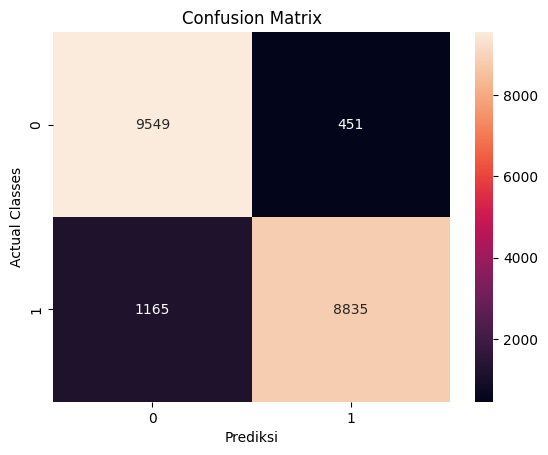

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

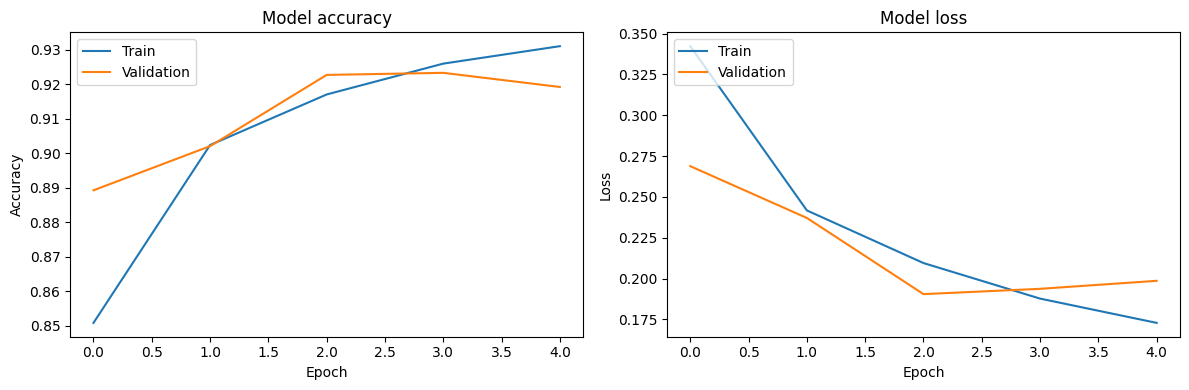

In [14]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# simpan model
model_save = model1.save('model_skenario1.h5')

## Skenario 2

In [16]:
# # mendefinisikan model
# model2 = models.Sequential()

# # convolutional layers
# model2.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(weight, height, 3) ))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(128, (3, 3)))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(256, (3, 3)))
# model2.add(layers.MaxPooling2D((2, 2)))
# # Flatten layer
# model2.add(layers.Flatten())

# # dense layers
# model2.add(layers.Dense(512, activation='relu'))
# model2.add(layers.Dropout(0.5))
# model2.add(layers.Dense(1, activation='sigmoid'))
# Mendefinisikan model
model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(weight, height, 3), padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model2.add(layers.Flatten())

# Dense layers
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,729 (3.49 MB)

 Trainable params: 913,729 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# optimizer adam dan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model2.compile(optimizer= optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [19]:
history = model2.fit(train_dataset,
                    epochs = 100,
                    validation_data = test_dataset,callbacks=[callback])

Epoch 1/100
   8/3125 ━━━━━━━━━━━━━━━━━━━━ 1:22 26ms/step - accuracy: 0.4814 - loss: 0.6996 - precision_1: 0.4875 - recall_1: 0.5063

W0000 00:00:1717173528.837245      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8453 - loss: 0.3392 - precision_1: 0.8474 - recall_1: 0.8398

W0000 00:00:1717173618.533569      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 34ms/step - accuracy: 0.8453 - loss: 0.3392 - precision_1: 0.8474 - recall_1: 0.8398 - val_accuracy: 0.9190 - val_loss: 0.2030 - val_precision_1: 0.8949 - val_recall_1: 0.9495
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9233 - loss: 0.1941 - precision_1: 0.9221 - recall_1: 0.9248 - val_accuracy: 0.9316 - val_loss: 0.1738 - val_precision_1: 0.9388 - val_recall_1: 0.9234
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9361 - loss: 0.1642 - precision_1: 0.9348 - recall_1: 0.9379 - val_accuracy: 0.9337 - val_loss: 0.1748 - val_precision_1: 0.9178 - val_recall_1: 0.9528
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9433 - loss: 0.1448 - precision_1: 0.9425 - recall_1: 0.9444 - val_accuracy: 0.9377 - val_loss: 0.1616 - val_precision_1: 0.9332 - val_recall_1: 0.9429
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 109s 35ms/step - accuracy: 0.9508 - loss: 0.1263 - precision_1: 0.9497 - 

#### Prediksi data test

In [20]:
# buat prediksi
prediksi = model2.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step


In [21]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [22]:
# Make predictions on the test data
predict_prob = model2.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step

Accuracy: 0.94625

Confusion Matrix:
[[9498  502]
 [ 573 9427]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.94      0.95      0.95     10000
        REAL       0.95      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Mean Average Precision (mAP): 0.9880374074771587


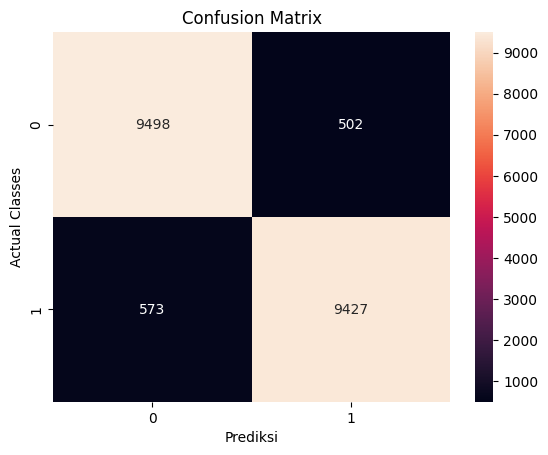

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

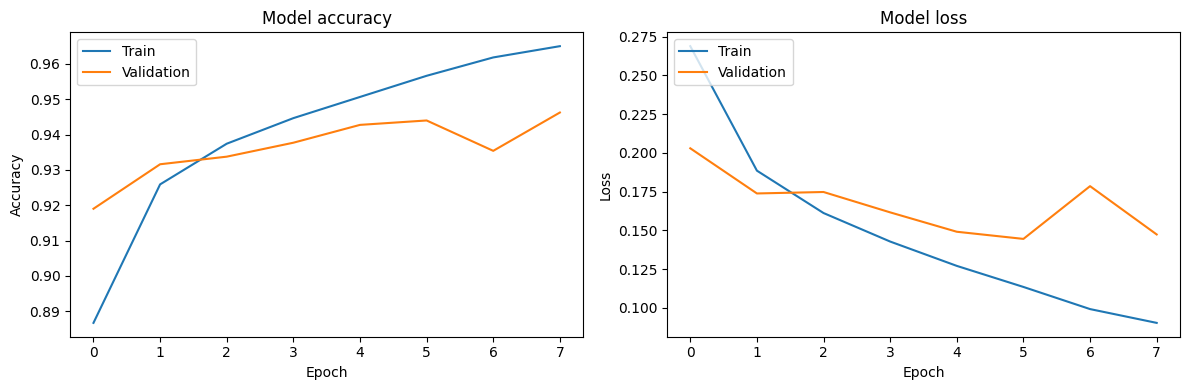

In [24]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
# simpan model
model_save = model2.save('model_skenario2.h5')

## Skenario Transfer Learning VGG16

In [26]:
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                        input_tensor=Input(shape=(32, 32, 3)))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
modelVGG16.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [29]:
history = modelVGG16.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=100,callbacks=[callback]
)

Epoch 1/100
   5/3125 ━━━━━━━━━━━━━━━━━━━━ 1:41 33ms/step - accuracy: 0.4540 - loss: 3.2305 - precision_2: 0.3791 - recall_2: 0.4525

W0000 00:00:1717174504.712584      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6795 - loss: 0.5687 - precision_2: 0.6776 - recall_2: 0.6700

W0000 00:00:1717174601.711042      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 128s 37ms/step - accuracy: 0.6795 - loss: 0.5687 - precision_2: 0.6777 - recall_2: 0.6701 - val_accuracy: 0.9065 - val_loss: 0.2313 - val_precision_2: 0.9356 - val_recall_2: 0.8731
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 127s 40ms/step - accuracy: 0.9120 - loss: 0.2240 - precision_2: 0.9114 - recall_2: 0.9129 - val_accuracy: 0.9251 - val_loss: 0.1949 - val_precision_2: 0.9356 - val_recall_2: 0.9129
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 36ms/step - accuracy: 0.9313 - loss: 0.1772 - precision_2: 0.9325 - recall_2: 0.9295 - val_accuracy: 0.9311 - val_loss: 0.1729 - val_precision_2: 0.9679 - val_recall_2: 0.8918
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 111s 36ms/step - accuracy: 0.9363 - loss: 0.1751 - precision_2: 0.9410 - recall_2: 0.9300 - val_accuracy: 0.9204 - val_loss: 0.2010 - val_precision_2: 0.9086 - val_recall_2: 0.9350
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 119s 38ms/step - accuracy: 0.9281 - loss: 0.1834 - precision_2: 0.9297 - 

In [30]:
# buat prediksi
prediksi = modelVGG16.predict(test_dataset)

  8/625 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step

W0000 00:00:1717176215.365811      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step


In [31]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [32]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step

Accuracy: 0.5

Confusion Matrix:
[[    0 10000]
 [    0 10000]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00     10000
        REAL       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000


Mean Average Precision (mAP): 0.5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


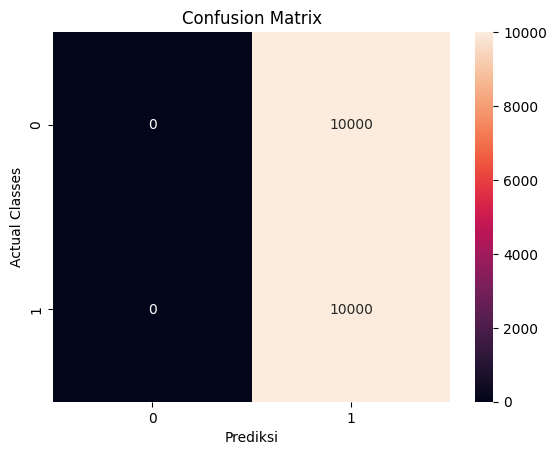

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

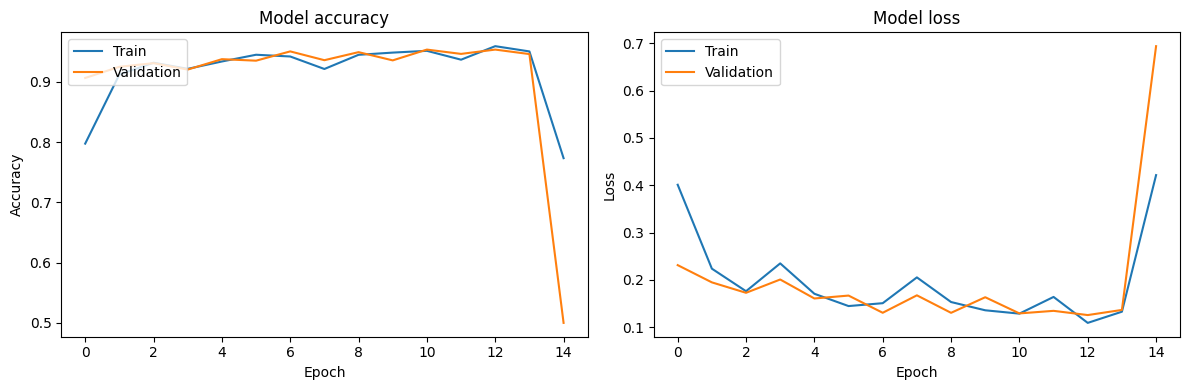

In [34]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# simpan model
model_save = modelVGG16.save('model_vgg16.h5')

In [36]:
# define dependency 
from tensorflow.keras.models import load_model

# load model 
model = load_model('model_vgg16.h5')

# check model info 
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,043 (56.76 MB)

 Trainable params: 14,879,041 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Test data diluar dataset

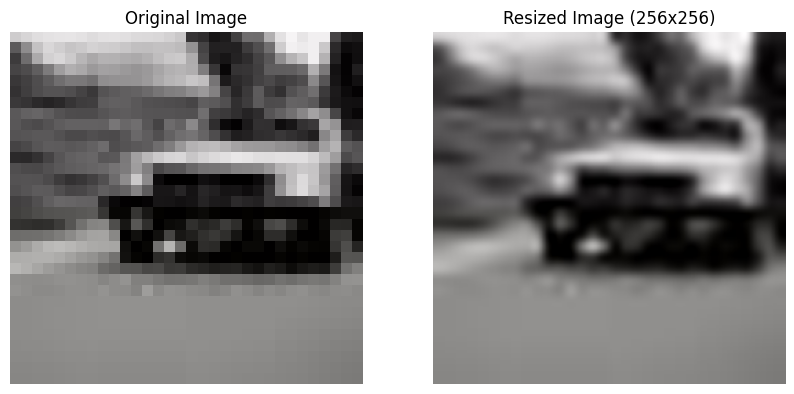

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the original image
im = Image.open("/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/1000 (2).jpg")

# Define the new size
new_size = (256, 256)

# Resize the image
im_resized = im.resize(new_size)

# Plot the original and resized images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original Image')
plt.axis('off')

# Plot the resized image
plt.subplot(1, 2, 2)
plt.imshow(im_resized)
plt.title('Resized Image (256x256)')
plt.axis('off')

plt.show()

In [38]:
# test_dir = "/kaggle/input/data-testing/data luar"
test_dir = "/kaggle/input/data-testing/data_luar_v2/data_luar_v2"

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  class_mode='binary', shuffle=False)

Found 20 images belonging to 2 classes.


In [40]:
model1 = load_model('/kaggle/working/model_skenario1.h5')
model2 = load_model('/kaggle/working/model_skenario2.h5')
modelVGG16 = load_model('/kaggle/working/model_vgg16.h5')

#### akurasi model

In [41]:
# model 1
scores = model1.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6500 - loss: 0.7827 - precision: 0.6154 - recall: 0.8000
Baseline error: 0.35
Accuracy = 0.65


W0000 00:00:1717176372.665732      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [42]:
# model 2
scores = model2.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - loss: 0.8604 - precision_1: 0.6667 - recall_1: 0.8000
Baseline error: 0.30
Accuracy = 0.70


W0000 00:00:1717176382.915802      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [43]:
# model vgg16
scores = modelVGG16.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6936 - precision_2: 0.5000 - recall_2: 1.0000
Baseline error: 0.50
Accuracy = 0.50


W0000 00:00:1717176394.681853      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [44]:
# Make predictions on the test data
predict_prob = model1.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step

Accuracy: 0.65

Confusion Matrix:
[[5 5]
 [2 8]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.71      0.50      0.59        10
        REAL       0.62      0.80      0.70        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20


Mean Average Precision (mAP): 0.7821767040149392


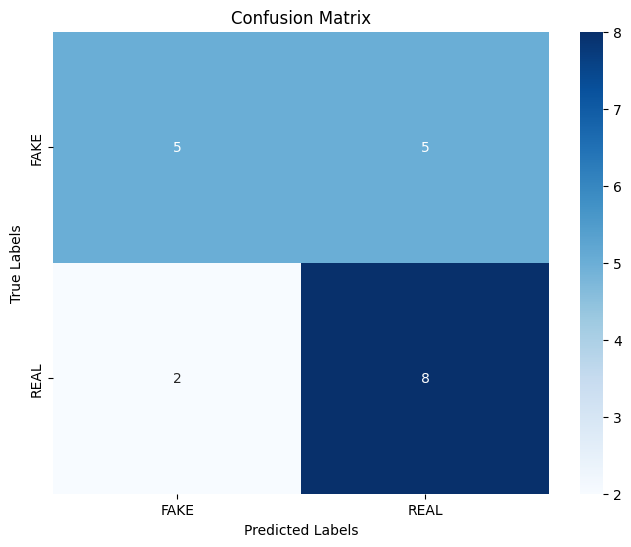

In [45]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Make predictions on the test data
predict_prob = model2.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step

Accuracy: 0.7

Confusion Matrix:
[[6 4]
 [2 8]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.75      0.60      0.67        10
        REAL       0.67      0.80      0.73        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20


Mean Average Precision (mAP): 0.8426619132501485


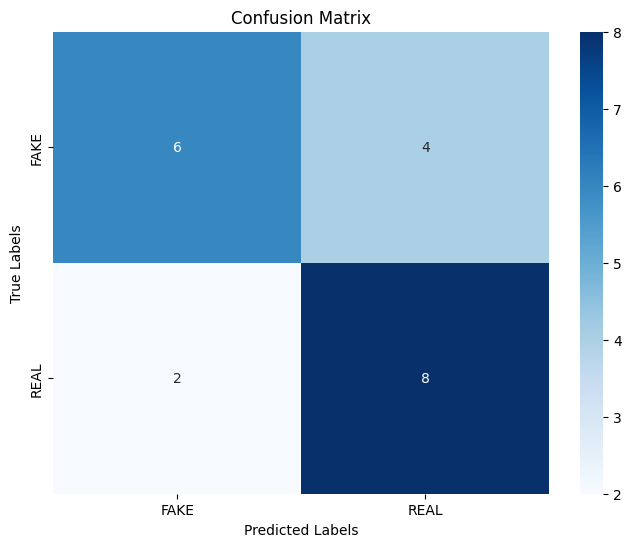

In [47]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step

Accuracy: 0.5

Confusion Matrix:
[[ 0 10]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00        10
        REAL       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20


Mean Average Precision (mAP): 0.5


W0000 00:00:1717176439.212107      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

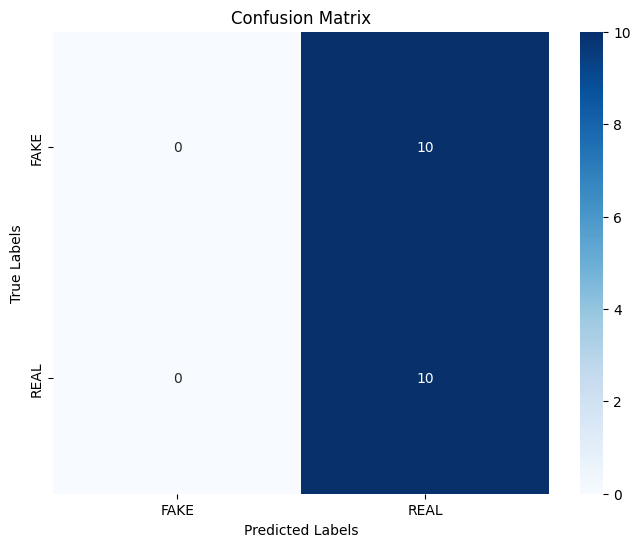

In [49]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()